# Making a Telescope Point Spread Function

This tutorial introduces the basic elements in HCIpy and makes a broadband PSF from a telescope.

In [1]:
import numpy as np
import matplotlib.pyplot as plt
%matplotlib inline

import matplotlib as mpl
mpl.rc('image', interpolation='nearest', origin='lower')
mpl.rcParams.update({'font.size': 22})
plt.rc('figure', figsize=(10.0, 10.0))


from hcipy import *

We will make monochromatic point spread functions (PSFs) for a telescope, and introduce the basic elements in HCIPy. We'll start by making a telescope pupil, then explain the code below.

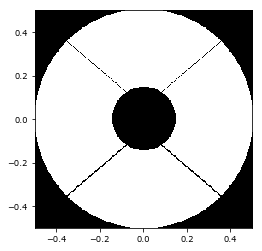

In [2]:
pupil_grid = make_pupil_grid(256)

aperture = make_magellan_aperture(True)

telescope_pupil = aperture(pupil_grid)

imshow_field(telescope_pupil, cmap='gray')
plt.show()

The basic unit is `Coords` - by themselves, they are a number or a list of numbers with no units or coordinate system specified on their own.

You can then make a `Grid` out of `Coords` along with a specified coordinate system, for example Cartesian, Polar or even Hexagonal, along with a way of specifying the spatial positions of the `Coords`.

Finally there is a `Field`, which specifies the values on that `Grid` - so to plot something in HCIPy, you are plotting a `Field` that has a `Grid` associated with it.

The `Field` is a one-dimensional list of values, but the associated `Grid` tells you the `(x,y)` or `(r, theta)` positions of the actual points. There are functions in HCIPy that handle the most used `Grid`s such as regularly spaced grids, and displays them.

`make_pupil_grid()` did three things - it made a list of `Coords` to be put into a regularly-spaced grid, then made a `CartesianGrid` that tells us that the `Coords` are to be interpreted in a Cartesian coordinate system, and finally it's stored in `pupil_grid`. But we don't have any `Field` values associated with that `CartesianGrid` - so what's next?

We now use a `Field` generator, called `make_magellan_aperture()`, which returns a function that you can then evaluate on any `Grid`, be it Cartesian or Polar. This is stored into a variable that is called `aperture`.

We then run the function `aperture` on the `CartesianGrid` object `pupil_grid` to make a `Field` called `telescope_pupil` and we then display it as an image using the HCIPy function `imshow_field`.

We now have the telescope pupil for the [Magellan 6.5m telescope](https://obs.carnegiescience.edu/Magellan) at Las Campanas Observatory in Chile. Let's immediately make the point spread function (PSF) for the telescope, and then talk about what we've done.

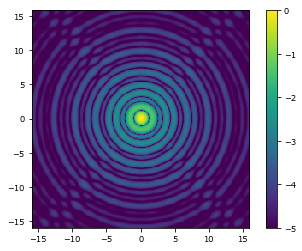

In [3]:
wavefront = Wavefront(telescope_pupil, 1)

focal_grid = make_focal_grid(pupil_grid, 8, 16)

prop = FraunhoferPropagator(pupil_grid, focal_grid)

focal_image = prop.forward(wavefront)

imshow_field(np.log10(focal_image.intensity / focal_image.intensity.max()), vmin=-5)
plt.colorbar()
plt.show()

We want to see what happens when we image a point source (such as a distant star) with a telescope that has this particular telescope pupil geometry.

The function `Wavefront` assigns a wavelength of 1 to the `Field` called `telescope_pupil` and produces an object called `wavefront` with a new object type called `Wavefront`.

We then make a `CartesianGrid` representing the output focal plane with `make_focal_grid()`, and the size of the image is measured in diffraction widths - the sampling is 8 pixels per diffraction width, and the half size of the image is 16 diffraction widths.

We then need to do two more things - tell HCIPy how we want to propagate the field from the pupil plane to the focal plane, and then actually perform the calculation.

The propagator is defined with `FraunhoferPropagator(pupil_grid, focal_grid)`, and then we carry out the calculation on the specific `wavefront` with `prop.forward(wavefront)` and the resultant `Wavefront` in the camera focal plane is `focal_image`.

Next, we want to take a cut across this image to see what how the flux changes as a function of angular separation from the on-axis position in units of diffraction widths $(\lambda/D)$.

`focal_image` is a `Wavefront` object, which has several properties including `intensity`, so we use that:

In [4]:
psf = focal_image.intensity

Next we want to know the size and shape of the `psf`, but it's stored as a 1D list of values. We call the `shaped` method to get a reshaped version of `psf`, which has the shape according to its grid, and then call `shape` to return a 2 element array with the dimensions of `psf`.

In [5]:
psf_shape = psf.shaped.shape
print(psf_shape)

(256, 256)


We then cut out the middle row from the image using `[:,psf_shape[0]//2]` remembering that we need to have shaped the `psf` first before doing the slicing, and then we normalise the slice by the peak value of the `psf` image.

In [6]:
slicefoc = psf.shaped[:,psf_shape[0]//2]

slicefoc_normalised = slicefoc / psf.max()

Finally we plot out the normalised slice. Note that HCIPy keeps track of the units and coordinates so that you don't have to propagate them yourself and risk making an error in the process - we get the units by taking the `x` values from the `focal_grid`, remembering to `reshape` them to a 2D array, and then slicing out one of the rows and using these values for the x axis of our plot:

(-5, 0.1)

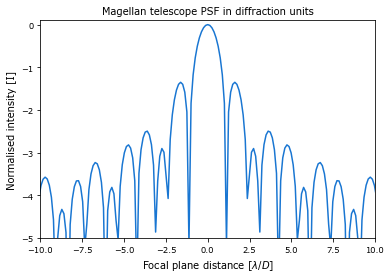

In [7]:
plt.plot(focal_grid.x.reshape(psf_shape)[0,:], np.log10(slicefoc_normalised))
plt.xlabel('Focal plane distance [$\lambda/D$]')
plt.ylabel('Normalised intensity [I]')
plt.title('Magellan telescope PSF in diffraction units')
plt.xlim(-10,10)
plt.ylim(-5,0.1)

We've plotted up the monochromatic case, but now let's see the effect for broadening the range of wavelengths through our telescope - we adjust the wavelength in the `wavefront`, then calculate the intensity image and add them together for several different wavelengths. We pick 11 monochromatic PSFs over the fractional bandwidth:

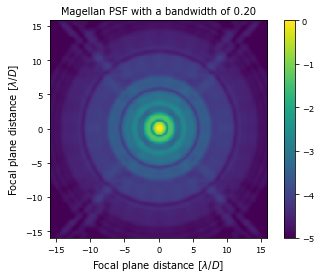

In [8]:
bandwidth = 0.2

focal_total = 0
for wlen in np.linspace(1 - bandwidth / 2., 1 + bandwidth / 2., 11):
    wavefront = Wavefront(telescope_pupil, wlen)
    focal_total += prop(wavefront).intensity
    
imshow_field(np.log10(focal_total / focal_total.max()), vmin=-5)

plt.title('Magellan PSF with a bandwidth of {:.2f}'.format(bandwidth))
plt.xlabel('Focal plane distance [$\lambda/D$]')
plt.ylabel('Focal plane distance [$\lambda/D$]')
plt.colorbar()
plt.show()